In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Lyon-BSA encoded spike data of shape (num samples, num iterations, num channels). For example, matlab converted TI46 dataset would have the shape (18000, 1000, 77) [num iterations = 1000, with decimation factor 12, to the best of my knowledge], and python converted google mini-speech dataset would have the shape (8000, 1378, 96) 

In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/tf_LSM/'
x_data = np.load(data_path + 'mini_speech_data_decimation_16.npy')
y_data = np.load(data_path + 'mini_speech_label_decimation_16.npy')

In [ ]:
print(x_data.shape)
print(y_data.shape)

(8000, 1378, 96)
(8000,)


In [ ]:
print(x_data.dtype)

int8


In [ ]:
data_size_test = x_data.shape[0]//5 

x_test=np.array(x_data[-data_size_test:])
y_test=np.array(y_data[-data_size_test:])
x_in_train=np.array(x_data[:-data_size_test])
y_in_train=np.array(y_data[:-data_size_test])

data_size = x_in_train.shape[0]

defining the input and Liquid weights

In [ ]:
Nx = 12
Ny = 12
Nz = 12
N = Nx*Ny*Nz
LqW = 3
in_conn_density = 0.15
inh_fr = 0.2
lam = 9

in_size = x_data.shape[2]

W_lsm = np.zeros((N,N))
W_in = np.zeros((in_size,N))
W_lsm_mask = np.ones((N,N))

in_conn_range = np.int32(N*in_conn_density)
for i in range(in_size):
  input_perm_i = np.arange(N)
  np.random.shuffle(input_perm_i)
  pos_conn = input_perm_i[:in_conn_range]
  neg_conn = input_perm_i[-in_conn_range:]
  W_in[i,pos_conn] = LqW
  W_in[i,neg_conn] = -LqW

input_perm = np.arange(N)
np.random.shuffle(input_perm) # first 0.2*N indices are inhibitory
inh_range = np.int32(inh_fr*N) # indices 0 to inh_range-1 are inhibitory

for i in range(N):
  posti = input_perm[i] # input_perm[i] is the post-neuron index
  zi = posti//(Nx*Ny)
  yi = (posti-zi*Nx*Ny)//Nx
  xi = (posti-zi*Nx*Ny)%Nx
  for j in range(N):
    prej = input_perm[j] # input_perm[j] is the pre-neuron index
    zj = prej//(Nx*Ny)
    yj = (prej-zj*Nx*Ny)//Nx
    xj = (prej-zj*Nx*Ny)%Nx
    D = ((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2)
    if i<inh_range and j<inh_range: # II connection, C = 0.3
      P = 0.3*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
    if i<inh_range and j>=inh_range: # EI connection, C = 0.1
      P = 0.1*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = LqW
    if i>=inh_range and j<inh_range: # IE connection, C = 0.05
      P = 0.05*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
    if i>=inh_range and j>=inh_range: # EE connection, C = 0.2
      P = 0.2*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = LqW

for i in range(N):
  W_lsm[i,i] = 0
  W_lsm_mask[i,i] = 0

print("average fan out: ", np.mean(np.sum(W_lsm, axis=1)/LqW))

average fan out:  11.91087962962963


In [ ]:
def run_LSM(Vm, SI, Sin, SinI, eta, eta1, a1, a2, in_W, W, sc_W, th, n_iter):
  Sliq = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, sc_W*W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1)

# LSM with STDP in Liquid-Liquid (LL) connections
def run_LSM_LL_STDP(Vm, SI, Sin, SinI, spT, eta, eta1, a1, a2, in_W, W, th, n_iter, batch_s, Nin, Nrev, Ap, An, a3=0.1, eta2=0.1):
  Sliq = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout

    dwp = Ap*tf.matmul(tf.transpose(spT), Sout)/batch_s
    dwn = -An*tf.matmul(spT, tf.transpose(Sout))/batch_s
    W = W + dwp + dwn
    
    tau_astro = 10
    eta_astro = 1/tau_astro
    w_astro = 0.01
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), W, An

# LSM with STDP in Input-Liquid (IL) connections
def run_LSM_IL_STDP(Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, th, n_iter, batch_s, Nin, Nrev, Ap, An, a3=0.1, eta2=0.1):
  Sliq = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout
    spT_in = (1-eta2)*spT_in + a3*Sin[:,i,:]

    dwp = Ap*tf.matmul(tf.transpose(spT_in), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sin[:,i,:]), spT)/batch_s
    in_W = in_W + dwp + dwn

    tau_astro = 10
    eta_astro = 1/tau_astro
    w_astro = 0.01
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), in_W, An

# old version
'''
# LSM with STDP in all (LL and IL) connections
def run_LSM_full_STDP(Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, th, n_iter, batch_s, Nin, Nrev, Ap, An, a3=0.1, eta2=0.1):
  Sliq = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout
    spT_in = (1-eta2)*spT_in + a3*Sin[:,i,:]

    dwp = Ap*tf.matmul(tf.transpose(spT_in), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sin[:,i,:]), spT)/batch_s
    in_W = in_W + dwp + dwn
    
    dwp = Ap*tf.matmul(tf.transpose(spT), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sout), spT)/batch_s
    W = W + dwp + dwn
    
    tau_astro = 10
    eta_astro = 1/tau_astro
    w_astro = 0.01
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), in_W, W, An
'''

# new version
# LSM with STDP in all (LL and IL) connections
def run_LSM_full_STDP(Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, in_W_sign, W, W_sign, W_mask, th, n_iter, batch_s, Nin, Nrev, Ap, An, dw_in_scale=1, dw_lsm_scale=1, a3=0.1, eta2=0.1):
  Sliq = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout
    spT_in = (1-eta2)*spT_in + a3*Sin[:,i,:]

    dwp = Ap*tf.matmul(tf.transpose(spT_in), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sin[:,i,:]), spT)/batch_s
    in_W = in_W + dw_in_scale*(dwp + dwn)

    #in_W_check = in_W*in_W_sign
    #in_W = in_W*tf.cast(in_W_check>=0, dtype=tf.float32)
    
    dwp = Ap*tf.matmul(tf.transpose(spT), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sout), spT)/batch_s
    W = (W + dw_lsm_scale*(dwp + dwn))*W_mask

    W_check = W*W_sign
    W = W*tf.cast(W_check>=0, dtype=tf.float32)
    
    tau_astro = 10
    eta_astro = 1/tau_astro
    w_astro = 0.01
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), in_W, W, An



In [ ]:
#load W_lsm from MNIST task
#W_lsm_multi = np.load(data_path + '/params_v1/W_lsm_multi.npy')

In [ ]:
batch_size = 200
num_iter = x_data.shape[1]

W_lsm_tf = tf.constant(W_lsm, dtype=tf.float32)

# Try multimodal W_lsm from MNIST
#W_lsm_tf = tf.constant(W_lsm_multi, dtype=tf.float32)

W_in_tf = tf.constant(W_in, dtype=tf.float32)

eta = 0.1
eta1 = 0.1
a1 = 0.1
a2 = 0.1
th = 5

num_batches = data_size//batch_size
num_batches_test = data_size_test//batch_size
num_partitions = 4
LSM_out_train = np.zeros((x_in_train.shape[0],num_partitions*N))
LSM_out_test = np.zeros((x_test.shape[0],num_partitions*N))

w_scale = 1
partition = num_iter//num_partitions

for b in range(num_batches):
  if(b%4==0):
    print("completed: ", b/num_batches)
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)

  batch_in_full = x_in_train[b*batch_size:(b+1)*batch_size]
  batch_in_full_tf = tf.constant(batch_in_full, dtype=tf.float32)

  S_liq = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)
  
  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)
  
  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)

  #S_liq_c = tf.reduce_mean(S_liq, axis=1)

  LSM_out_train[b*batch_size:(b+1)*batch_size] = S_liq_c.numpy()

for b in range(num_batches_test):
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)

  batch_in_full = x_test[b*batch_size:(b+1)*batch_size]
  batch_in_full_tf = tf.constant(batch_in_full, dtype=tf.float32)

  S_liq = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)
  
  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)
  
  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)

  #S_liq_c = tf.reduce_mean(S_liq, axis=1)

  LSM_out_test[b*batch_size:(b+1)*batch_size] = S_liq_c.numpy()

completed:  0.0
completed:  0.125
completed:  0.25
completed:  0.375
completed:  0.5
completed:  0.625
completed:  0.75
completed:  0.875


In [ ]:
print("mean LSM spiking (train) : ", np.mean(LSM_out_train))
print("mean LSM spiking (test) : ", np.mean(LSM_out_test))

print("mean input spiking (train) : ", np.mean(x_data))
print("mean input spiking (test) : ", np.mean(x_test))

mean LSM spiking (train) :  0.025606021118019007
mean LSM spiking (test) :  0.02558840188188103
mean input spiking (train) :  0.1725877847952951
mean input spiking (test) :  0.17265486098512337


training linear model on LSM
train score = 0.93296875
test score = 0.749375


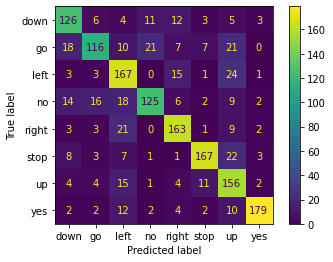

In [ ]:
from sklearn import linear_model
from sklearn.metrics import ConfusionMatrixDisplay

print("training linear model on LSM")
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
clf.fit(LSM_out_train, y_in_train)

train_score = clf.score(LSM_out_train, y_in_train)
print("train score = " + str(train_score))

score = clf.score(LSM_out_test, y_test)
print("test score = " + str(score))

test_predict = clf.predict(LSM_out_test)
cm = confusion_matrix(y_test, test_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

#print("training linear model on direct input")
#clf2 = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
#clf2.fit(np.mean(x_in_train, axis=(1)), y_in_train)

#score2 = clf2.score(np.mean(x_test, axis=(1)), y_test)
#print("test score without LSM = " + str(score2))

In [ ]:
# save linear classifier
#pickle.dump(clf, open(data_path + 'lin_model_sp.sav', 'wb'))

In [ ]:
# save Weights
#np.save(data_path + 'W_in_sp', W_in)